In [2]:
#imports
import os, glob, json
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps

from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import selections
from enterprise.signals.selections import Selection

from enterprise_extensions import models, hypermodel
from enterprise_extensions.model_utils import bayes_fac
from la_forge import core, diagnostics

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

# Make my pulsar objects

In [3]:
datadir = './20_pulsars/WN_only/'
parfiles = sorted(glob.glob(datadir+'Pars/*'))
timfiles = sorted(glob.glob(datadir+'Tims/*'))

psrs = []
for p, t in zip(parfiles,timfiles):
    psr = Pulsar(p,t)
    psrs.append(psr)

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


# Make signal model

In [13]:
selection = selections.Selection(selections.by_backend)

#WN parameters
efac = parameter.Uniform(0.0,10)
equad = parameter.Uniform(-8.5,-5)
ecorr = parameter.Uniform(-8.5,-5)

#white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.TNEquadNoise(log10_tnequad=equad,selection=selection)

#timing model
tm = gp_signals.TimingModel(use_svd=True)

#full model
s = tm + ef + eq

my_pta = signal_base.PTA(s(psrs[0]))

# do sampling

In [31]:
x0 = np.hstack([p.sample() for p in my_pta.params])
ndim = len(x0)

outdir = './chains'
os.makedirs(outdir, exist_ok=True)

cov = np.diag(np.ones(ndim))

sampler = ptmcmc(ndim, my_pta.get_lnlikelihood, my_pta.get_lnprior, cov, outDir=outdir, resume=False)

num_samps = int(10e5)
print(num_samps)
sampler.sample(x0, num_samps,SCAMweight=30, AMweight=15, DEweight=50, )

1000000
Finished 0.00 percent in 0.000426 s Acceptance rate = 0

/home/mitch/miniconda3/envs/enterprise/lib/python3.10/site-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 1.00 percent in 3.004343 s Acceptance rate = 0.238833Adding DE jump with weight 50
Finished 100.00 percent in 298.845104 s Acceptance rate = 0.324682
Run Complete


# check chain

In [42]:
chain = np.loadtxt(outdir + '/chain_1.txt',delimiter='\t')
burn = int(0.1 * chain.shape[0])


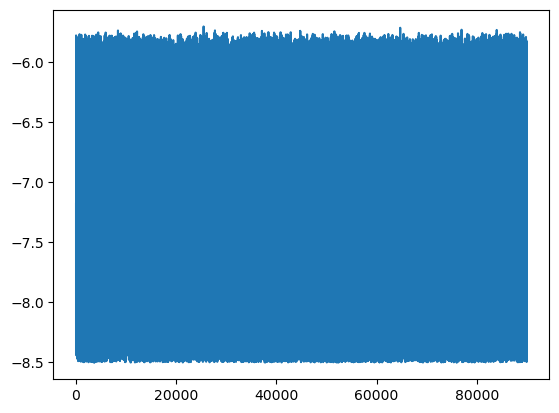

In [44]:
plt.plot(chain[burn:, 1])

(array([1.490e+02, 1.930e+02, 1.770e+02, 1.490e+02, 1.330e+02, 1.680e+02,
        2.060e+02, 1.560e+02, 1.670e+02, 1.530e+02, 1.470e+02, 1.280e+02,
        1.520e+02, 2.250e+02, 1.890e+02, 2.110e+02, 1.670e+02, 2.130e+02,
        2.540e+02, 2.120e+02, 2.030e+02, 2.180e+02, 2.010e+02, 1.990e+02,
        2.110e+02, 2.130e+02, 2.390e+02, 2.250e+02, 2.750e+02, 2.400e+02,
        2.170e+02, 2.580e+02, 2.770e+02, 2.400e+02, 2.580e+02, 2.460e+02,
        2.450e+02, 2.530e+02, 2.750e+02, 2.680e+02, 2.810e+02, 2.800e+02,
        2.920e+02, 3.190e+02, 3.120e+02, 3.310e+02, 3.610e+02, 3.670e+02,
        4.090e+02, 3.600e+02, 4.300e+02, 4.270e+02, 4.760e+02, 4.800e+02,
        4.990e+02, 5.750e+02, 6.210e+02, 7.520e+02, 8.560e+02, 1.067e+03,
        1.405e+03, 1.813e+03, 2.473e+03, 3.006e+03, 3.701e+03, 4.531e+03,
        5.169e+03, 5.860e+03, 5.885e+03, 5.790e+03, 5.768e+03, 5.127e+03,
        4.604e+03, 3.977e+03, 3.242e+03, 2.620e+03, 1.975e+03, 1.515e+03,
        1.144e+03, 8.110e+02, 5.840e+0

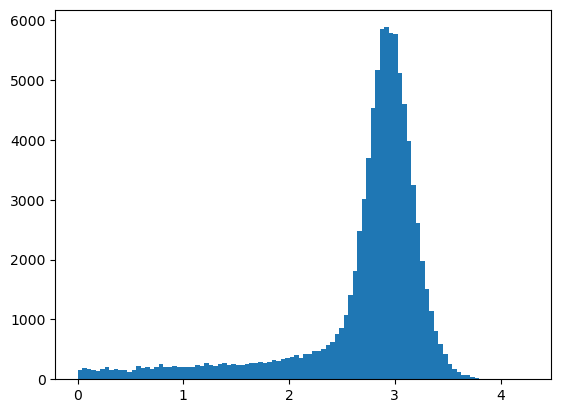

In [54]:
plt.hist(chain[burn:,0],bins=100)